**Imports and Configuration**
- **Purpose:** Sets up the Python environment with necessary libraries for data analysis and
visualization.

- **Actions:**

- Imports numpy, pandas, matplotlib.pyplot, and seaborn.

- Configures warning suppression to keep the output clean.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

**Data Loading**
- **Purpose:** Loads multiple Excel datasets required for the analysis.

- **Actions:**

- Reads state_codes.xlsx into df.

- Reads States_All_Vehicle_Registrations_2018.xlsx twice: first (df1) to locate the
header row, then (df2) to load the actual data, selecting specific columns for 'State'
and total vehicle counts.

- Reads States_Electric_Vehicle_Registrations_2018.xlsx into df3, selecting
'State' and 'Registration Count'.

- Reads States_Annual_Energy_Generation_Sources_1990_2019.xlsx into df4.

In [2]:
df = pd.read_excel("state_codes.xlsx")
df1 = pd.read_excel("States_All_Vehicle_Registrations_2018.xlsx", header=None)
header_row = df1[df1[0] == 'STATE'].index[0]
df2 = pd.read_excel("States_All_Vehicle_Registrations_2018.xlsx", header=header_row).iloc[:, [0, 15]]
df2.columns = ['State', 'Total_Vehicles']
df3 = pd.read_excel("States_Electric_Vehicle_Registrations_2018.xlsx", header=2)[['State', 'Registration Count']]
df4 = pd.read_excel("States_Annual_Energy_Generation_Sources_1990_2019.xlsx", header=1)

**Data Cleaning (Total Vehicles)**
- **Purpose:** Cleans the total vehicle registration numbers.

- **Actions:**

- Removes commas from the 'Total_Vehicles' column in df2.

- Converts the column to numeric type, handling errors by coercing them to NaN.

In [3]:
df2['Total_Vehicles'] = pd.to_numeric(df2['Total_Vehicles'].astype(str).str.replace(',', ''), errors='coerce')

In [4]:
df3.columns = ['State', 'EV_Count']

**Renaming Columns**
- **Purpose:** Standardizes column names for consistency.

- **Actions:**

- Renames columns in df3 to 'State' and 'EV_Count'.

In [5]:
df4 = df4[df4['TYPE OF PRODUCER'] == 'Total Electric Power Industry']
energy_pivot = df4.pivot_table(index=['YEAR', 'STATE'], columns='ENERGY SOURCE', values='GENERATION (Megawatthours)', aggfunc='sum').reset_index().fillna(0)

**Data Filtering and Pivoting (Energy Data)**
- **Purpose:** Prepares the energy generation data for analysis.

- **Actions:**

- Filters df4 to include only rows where the producer type is 'Total Electric Power
Industry'.

- Pivots the table to have years and states as indices and energy sources as columns,
aggregating by sum and filling missing values with 0.

In [6]:
energy_pivot = energy_pivot.merge(df, left_on='STATE', right_on='state_code')

**Merging Data (Energy & State Codes)**
- **Purpose:**
- Adds standardized state codes to the energy data.

- **Actions:**

- Merges the pivoted energy dataframe with the state codes dataframe (df) based
on state names/codes.

In [7]:
master = df3.merge(df2, on='State').merge(energy_pivot[energy_pivot['YEAR'] == 2018], left_on='State', right_on='state_name')

**Creating the Master Dataset**
- **Purpose:** Combines all processed datasets into a single master dataframe.

- **Actions:**

- Merges EV registration data (df3) with total vehicle data (df2).

- Further merges this with the energy data for the year 2018.

In [8]:
master['EV_Rate'] = master['EV_Count'] / master['Total_Vehicles']
master['Renewable'] = master[['Hydroelectric Conventional', 'Solar Thermal and Photovoltaic', 'Wind', 'Geothermal']].sum(axis=1)

**Feature Engineering**
- **Purpose:** Creates new analytical metrics.

- **Actions:**

- Calculates EV_Rate: The ratio of electric vehicles to total vehicles per state.

- Calculates Renewable: The sum of energy generated from Hydroelectric, Solar, Wind,
and Geothermal sources.

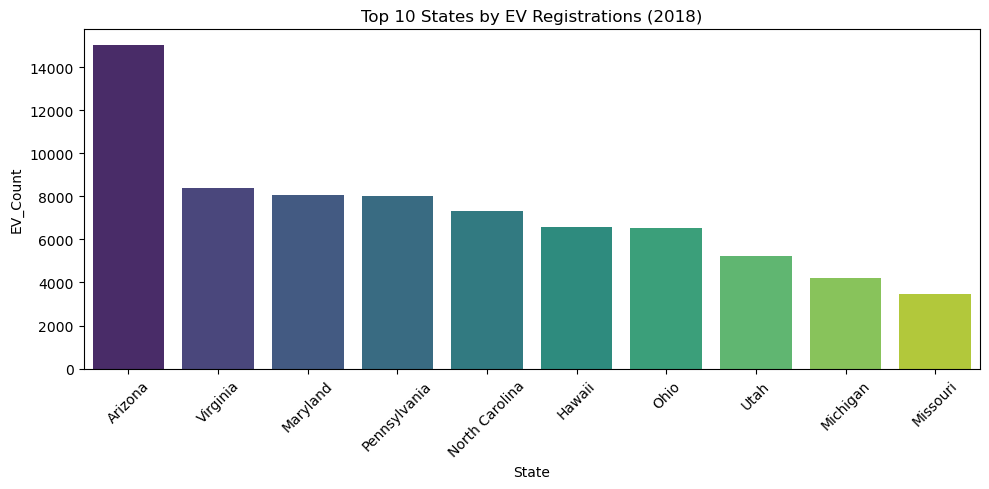

In [9]:
plt.figure(figsize=(10, 5))
sns.barplot(data=master.nlargest(10, 'EV_Count'), x='State', y='EV_Count', palette='viridis')
plt.title('Top 10 States by EV Registrations (2018)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Visualization - Top 10 States by EV Count**
- **Purpose:** Visualizes the states with the highest number of EV registrations.

- **Actions:**

- Creates a bar plot using seaborn showing the top 10 states by 'EV_Count'.

- The chart highlights California as the clear leader in EV adoption.

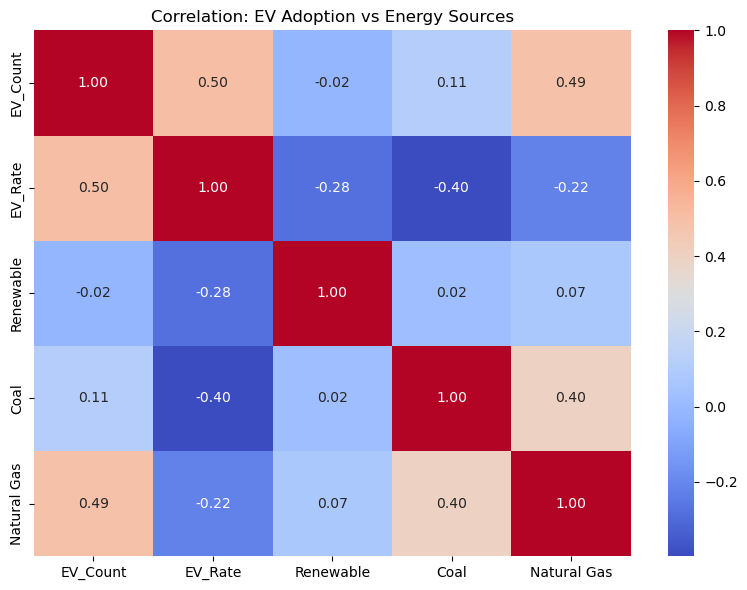

In [10]:
plt.figure(figsize=(8, 6))
sns.heatmap(master[['EV_Count', 'EV_Rate', 'Renewable', 'Coal', 'Natural Gas']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation: EV Adoption vs Energy Sources')
plt.tight_layout()
plt.show()

**Visualization - Correlation Heatmap**
- **Purpose:** Analyzes relationships between EV adoption and energy sources.

- **Actions:**

- Generates a heatmap to show correlation coefficients between 'EV_Count', 'EV_Rate',
and various energy sources (Renewable, Coal, Natural Gas).

- This helps identify if states with cleaner energy grids also have higher EV adoption rates.

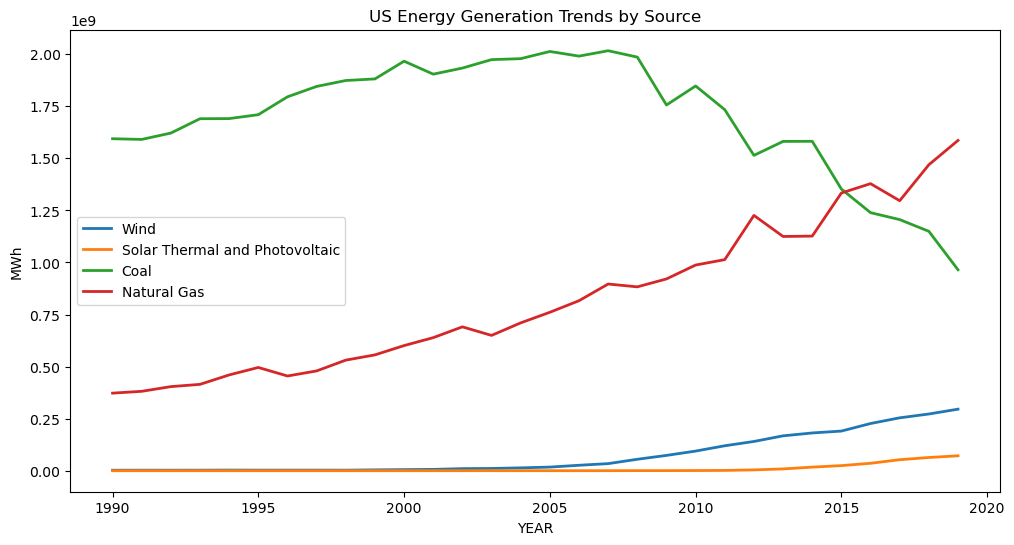

In [11]:
ts = energy_pivot.groupby('YEAR')[['Wind', 'Solar Thermal and Photovoltaic', 'Coal', 'Natural Gas']].sum()
ts.plot(figsize=(12, 6), linewidth=2)
plt.title('US Energy Generation Trends by Source')
plt.ylabel('MWh')
plt.show()

**Visualization - Energy Trends Over Time**
- **Purpose:** Tracks the historical trends of US energy generation sources.

- **Actions:**

- Groups the energy pivot table by 'YEAR' and sums the generation for key sources.

- Plots a line chart showing the trajectory of Wind, Solar, Coal, and Natural Gas from 1990
to 2019, revealing the rise of renewables and natural gas against the decline of coal